In [1]:
import importlib
import dbops
import utlis
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import glob

In [2]:
import pgvector.psycopg2


In [3]:
importlib.reload(dbops)  # Reload the module from source

<module 'dbops' from '/scratch/u1319464/Data-Mining-Spring-2025-Project/dbops.py'>

In [4]:
movie_ref = dbops.Movie.iterate_all_movies()[1]
str(movie_ref)

'Invasion of the Body Snatchers'

In [5]:
imdb_id = movie_ref.get_imdb_id()
title = movie_ref.get_title()
frame_idx_timeline = []
num_faces_timeline = []
color_timeline = []
for frame_ref in tqdm(movie_ref.iterate_frames()):
    # if not frame_ref.is_fully_cached():
    #     print(f'Uncached frame found: {frame_ref.frame_index}')
    
    frame_idx_timeline.append(frame_ref.frame_index)
    try:
        num_faces_timeline.append(frame_ref.get_num_faces())
    except:
        num_faces_timeline.append(0)
    
    c = frame_ref.get_average_color()
    color_timeline.append(c)

color_timeline = np.array(color_timeline)[:,0] / 255


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2646/2646 [00:00<00:00, 8230.72it/s]


Text(0.5, 1.0, 'Overall Processing Progress of "Invasion of the Body Snatchers"')

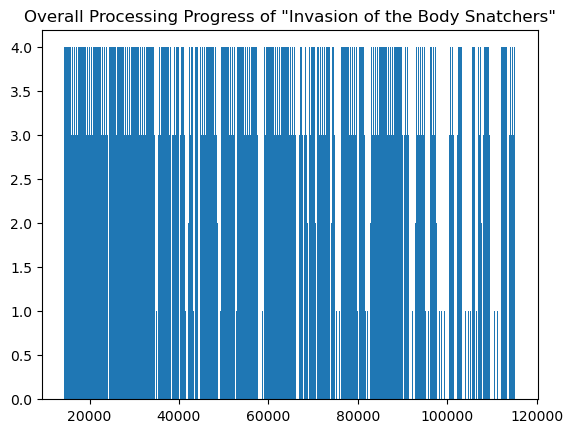

In [7]:
plt.hist(
    frame_idx_timeline,
    bins=15*60 # for every interval of ~15 seconds
)
plt.title(f'Overall Processing Progress of "{title}"')

In [8]:
color_timeline

array([[0.29791704, 0.2883989 , 0.2150414 ],
       [0.28453052, 0.28653648, 0.22548689],
       [0.28504652, 0.28771636, 0.2284928 ],
       ...,
       [0.5049884 , 0.48452246, 0.34362325],
       [0.4932489 , 0.4697898 , 0.3341134 ],
       [0.5104309 , 0.48901418, 0.3512224 ]], dtype=float32)

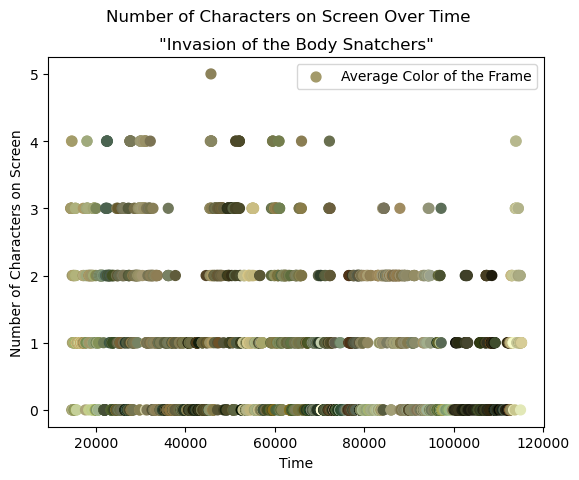

In [9]:

# draw lighter colors on top so we don't see just the darker ones
# draw_order = np.argsort(np.linalg.norm(color_timeline, axis=1))
draw_order = np.argsort(frame_idx_timeline)

plt.scatter(
    np.array(frame_idx_timeline)[draw_order],
    np.array(num_faces_timeline)[draw_order],
    s=50,
    c=utils.fudge_luminance(np.array(color_timeline)[draw_order], l=1.5),
    label='Average Color of the Frame',
    # marker='*'
)

# an obvious artifact seen in this figure is the overlapping of the lines
# this means that the camera was shooting around, and captured fewer people in some shots, whith more or all the characters in other shots
# this could be fixed by sliding a window over time to get the number of people in a scene rather than in a frame

plt.suptitle('Number of Characters on Screen Over Time')
plt.title(f'"{title}"')
plt.xlabel('Time')
plt.ylabel('Number of Characters on Screen')
plt.legend()
None

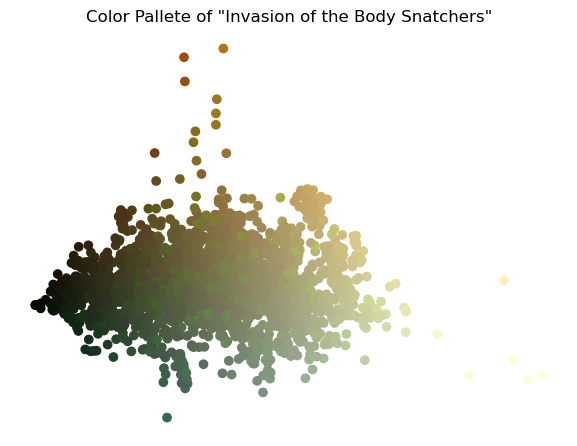

In [10]:
import numpy as np
from sklearn.decomposition import PCA

X = np.concatenate([
    color_timeline,
    # np.array(num_faces_timeline)[:,np.newaxis],
    # np.array(frame_idx_timeline)[:,np.newaxis]
], axis=1)

# Initialize PCA with 2 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], color=utils.fudge_luminance(color_timeline, l=1.5), label='PCA Transformed Data')
plt.title(f'Color Pallete of "{title}"')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
plt.tight_layout()
plt.axis('off')

plt.show()